In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

# Ignore UserWarnings issued by healpy
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="healpy")

sim_name = f"no_gravity"
sim_folder = f"sim_output/{sim_name}"
nu_mass_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")

# Simulation parameters.
with open(f'{sim_folder}/sim_parameters.yaml', 'r') as file:
    sim_setup = yaml.safe_load(file)
Nside = sim_setup["Nside"]
Npix = sim_setup["Npix"]
nu_per_pix = sim_setup["momentum_num"]
pix_sr = sim_setup["pix_sr"]

## Overdensity band

ic| tot_dens_halos.shape: (1, 50)


[[1.59231217e-10 1.96091337e-10 2.41483900e-10 2.97383939e-10
  3.66223625e-10 4.50998079e-10 5.55395652e-10 6.83958371e-10
  8.42279498e-10 1.03724682e-09 1.27734222e-09 1.57301057e-09
  1.93711401e-09 2.38549124e-09 2.93764634e-09 3.61759683e-09
  4.45491802e-09 5.48602883e-09 6.75577515e-09 8.31937938e-09
  1.02448408e-08 1.26158913e-08 1.55356343e-08 1.98891016e-08
  2.35583883e-08 2.90102081e-08 3.57234918e-08 4.39900637e-08
  5.41692394e-08 6.67034291e-08 8.21373454e-08 1.01141650e-07
  1.24542061e-07 1.58964808e-07 1.88832621e-07 2.32515250e-07
  2.86300052e-07 3.52522350e-07 4.34057022e-07 5.34443068e-07
  6.58036899e-07 8.10200972e-07 9.97535891e-07 1.26935041e-06
  1.51209076e-06 1.86161699e-06 2.29189064e-06 2.82155087e-06
  3.47353452e-06 4.27606553e-06]]


FileNotFoundError: [Errno 2] No such file or directory: 'figures/overdensity_band_no_gravity.pdf'

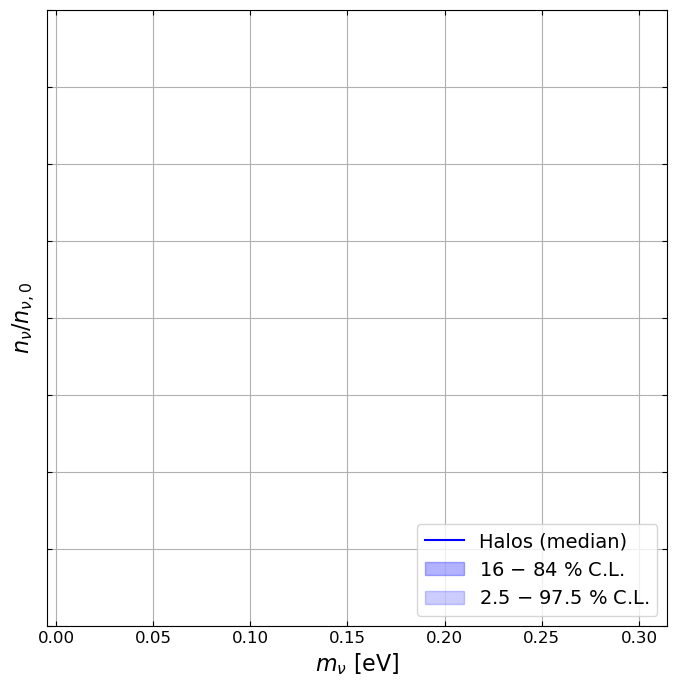

In [2]:
tot_dens_halos = jnp.load(f"{sim_folder}/total_densities.npy")
ic(tot_dens_halos.shape)
print(tot_dens_halos)
eta = 1e-12
SimPlot.overdensity_band(
    dens_arr=tot_dens_halos,
    m_arr=nu_mass_range,
    plot_ylims=((0-eta),(0+eta)),
    plot_log=False,
    fig_path=f"figures/overdensity_band_{sim_name}.pdf",
    args=Params())

## Anisotropy Skymaps and Power Spectra

In [ ]:
nu_vectors = jnp.load(f"{sim_folder}/vectors_halo1.npy")
print(nu_vectors)
ic(nu_vectors.shape)

nu_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_mass_range,
    pix_sr=pix_sr,
    args=Params())
ic(nu_dens.shape)

ic| nu_vectors.shape: (768, 5, 2, 6)


[[[[ 8.17800000e+00  0.00000000e+00  0.00000000e+00 -3.91294247e-18
    -3.91294247e-18 -5.40072969e-17]
   [ 1.52411316e+01  7.06313156e+00  9.74869029e+01 -3.91294247e-18
    -3.91294247e-18 -5.40072969e-17]]

  [[ 8.17800000e+00  0.00000000e+00  0.00000000e+00 -3.95466891e-18
    -3.95466891e-18 -5.45832144e-17]
   [ 1.53164507e+01  7.13845066e+00  9.85264739e+01 -3.95466891e-18
    -3.95466891e-18 -5.45832144e-17]]

  [[ 8.17800000e+00  0.00000000e+00  0.00000000e+00 -3.99684031e-18
    -3.99684031e-18 -5.51652733e-17]
   [ 1.53925729e+01  7.21457294e+00  9.95771304e+01 -3.99684031e-18
    -3.99684031e-18 -5.51652733e-17]]

  [[ 8.17800000e+00  0.00000000e+00  0.00000000e+00 -4.03946140e-18
    -4.03946140e-18 -5.57535392e-17]
   [ 1.54695070e+01  7.29150697e+00  1.00638991e+02 -4.03946140e-18
    -4.03946140e-18 -5.57535392e-17]]

  [[ 8.17800000e+00  0.00000000e+00  0.00000000e+00 -4.08253700e-18
    -4.08253700e-18 -5.63480781e-17]
   [ 1.55472614e+01  7.36926140e+00  1.01712175

ic| nu_dens.shape: (50, 768)


(50, 768)

ic| CNB_dens_1mass.shape: (768,)
ic| CNB_dens_1mass.min(): Array(9.10435114e-10, dtype=float64)
    CNB_dens_1mass.max(): Array(9.10435114e-10, dtype=float64)


FileNotFoundError: [Errno 2] No such file or directory: 'figures/skymaps_CNBxDM_no_gravity.pdf'

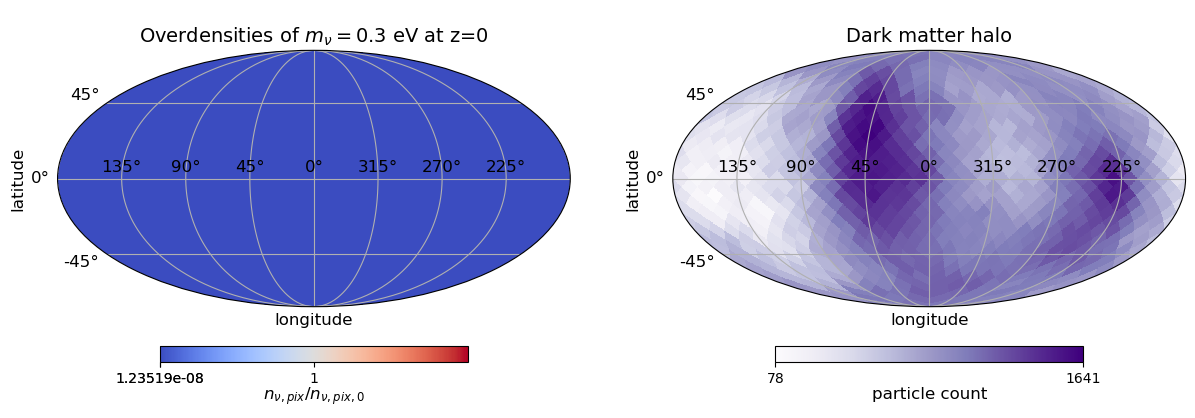

In [ ]:
# Choose which halo to plot
halo_i = 1

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
haloID = halo_indices[halo_i-1]

# Choose which neutrino mass to plot
m_val = 0.3
nu_mass_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
m_idx = jnp.abs(nu_mass_range - m_val).argmin()

# Load corresponding number densities
CNB_dens_1mass = nu_dens[m_idx]
ic(CNB_dens_1mass.shape)
ic(CNB_dens_1mass.min(), CNB_dens_1mass.max())

map = SimPlot.skymaps_CNBxDM(
    nu_mass=m_val, 
    CNB_dens=CNB_dens_1mass, 
    DM_halo_pos=jnp.load(f"Data/halo_grids/DM_pos_origID{haloID}_snap_0036.npy"), 
    init_xyz=jnp.load(f"{sim_folder}/init_xyz_halo{halo_i}.npy"), 
    fig_path=f"figures/skymaps_CNBxDM_{sim_name}.pdf",
    args=Params())